# Battle of the Midsize University Towns in US   

<img src="https://thumbor.forbes.com/thumbor/960x0/https%3A%2F%2Fspecials-images.forbesimg.com%2Fdam%2Fimageserve%2F761311672%2F960x0.jpg%3Ffit%3Dscale" width=400>
<div style="text-align: right"> (image from Internet) </div>


In this notebook, I collect data on the midsize university towns in US with population ranging from 30,000 to 150,000 and analyze the corresponding universities/colledges and venue distributions in town. Using unsupervised learning, the university towns are clustered based on their venues.

**Table of Contents**

0. [Introduction](#0)<br>
1. [Data Preparation](#1)<br>
    a. [University town list from wiki](#1.1)<br>
    b. [Population data of US cities](#1.2)<br>
    c. [Location data of US cities](#1.3)<br>
    d. [University data](#1.4)<br>
2. [Exploratory Data Analysis](#2)<br>
    a. [Town analysis](#2.1)<br>
    b. [University analysis](#2.2)<br>
3. [Clustering the University Towns](#3)<br>
    a. [Venue exploration](#3.1)<br>
    b. [K-means clustering](#3.2)<br>
    c. [Analysis of the Venue data](#3.3)<br>
4. [Conclusions](#4)<br>

**Main packages used**: *pandas*, *BeautifulSoup*, *matplotlib*, *folium*, *seaborn*, *numpy*, *sklearn*, *FourSquareAPI*.

## Introduction<a id="0"></a>

A __university town__ or __college town__ is a community that is dominated by its university population. In US, it is often a separate town or city, but in some cases it can also be a city neighborhood or district. University towns are usually considered to be some of the best places to live in because of their _**low cost of living**_, _**rich cultural activities**_, _**educational opportunities**_, _**fun**_ and _**sports**_, etc. 

With the stable consumption power coming from students, faculties, staff, and retirees, university towns are favored by numerous investors. Because university towns usually have students forming a major fraction of their population, businesses that typically cater to students are in huge demand in such places.


In this project, I will explore the midsize university towns in US to study their similarities and dissimilarities. By “midsize”, I meant to exclude the big cities with large populations. The reason is that cultures and business/life styles in large cities are influenced by many more factors compared with “university towns” where the university/institution plays important roles throughout the community. 


This study may be helpful to   
- _**investors**_ with the intension to open restaurants or bookstores in one of the university towns
- _**students**_ who are going to apply to colleges in the near future


## Data Preparation<a id="1"></a>
Four data sources are used:   
* [University town list from Wikipedia](https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States)     
Above wikipedia page provides the university towns all over the world in an unordered list. Cares need to be taken while scraping the list (multiple mistakes have been noticed in the list).    


* [US city location coordinates](https://simplemaps.com/data/us-cities)      
Instead of using geopy (which I found doesn't always return correct results?), I downloaded the geo data from above web site as csv file and processed by pandas. In the end, this dataset is also found to have errors.


* [US city populations (2017 population data)](https://www.biggestuscities.com/)   
Top 2000 cities are scraped from above website.


* [University data](https://collegescorecard.ed.gov/data/documentation/)     
The College Scorecard API is used to extract all the university-related data. This service provides data from 1996 through 2017 for all undergraduate degree-granting institutions of higher education.    
Here is the [Github repo](https://github.com/RTICWDT/college-scorecard) for the College Scorecard API.    
Note that there is a limit for API calls per day.


**Tools** used for web scraping: [requests](https://2.python-requests.org/en/master/), [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/).

In [1]:
# import library 
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup

from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import folium     # map rendering library

### (a) University town list from Wiki<a id="1.1"></a>
#### 1. Get the states of US

In [2]:
website_url = 'https://en.wikipedia.org/wiki/List_of_college_towns#College_towns_in_the_United_States'
tmp = requests.get(website_url).text
soup = BeautifulSoup(tmp,'lxml')

In [3]:
# Since US states are in level <h3> as other countries and regions,
# so we need to slice the part from "Alabama" to "Wyoming"
header3 = soup.findAll('h3')
region_list = []
for header in header3:
    region_list.append(header.text.split('[')[0])    # header.text has the format of 'name[edit]'

ind_start = region_list.index('Alabama')
ind_end = region_list.index('Wyoming')
us_states = region_list[ind_start:ind_end+1]
print('We got {} "states".'.format(len(us_states)))

We got 51 "states".


There are 50 states + DC in US.

#### 2 Get the univerisity towns in each state of US

In [4]:
# Get the towns in each states of US
# Each entity is in the format of 
#       'Albany (Albany State University)\nAlpharetta (Georgia State University, 
#        Gwinnett Technical College, Reinhardt University)\n ...'
list_unorder = soup.findAll('ul')
townlists = []
for lu in list_unorder:
    townlists.append(lu.text)

# The US part starts at ind = 59 and ends at ind = 124
# because some cities have unordered lists (ul) inside list.
# Some are indicated by cities/towns ended with '\xa0:'.
# e.g. 'Providence\xa0:' in us_UTown_lists[53]
us_UTown_lists = townlists[59:125]
print('Number of town list = {}'.format(len(us_UTown_lists)))
print('One example of the unordered list scrapped from Wikipeida.')
# One example of the extracted university town list
us_UTown_lists[53]

Number of town list = 66
One example of the unordered list scrapped from Wikipeida.


'Bristol (Roger Williams University)[31]\nKingston (University of Rhode Island)[9]\nNewport (Salve Regina University)\nProvidence\xa0:\nCollege Hill (Brown University - main campus, Rhode Island School of Design)\nDowntown (University of Rhode Island - Feinstein Providence Campus, Roger Williams University)[52]\nElmhurst (Providence College)\nJewelry District (Brown University - Alpert Medical School, Johnson and Wales University)\nLower South Providence (Community College of Rhode Island)\nManton (Rhode Island College)\nSmithfield (Bryant University)\nWarwick (Community College of Rhode Island)'

We got 66 strings (51 "states" + 15 sublists for those high university density regions). As the one example shown above, towns are separated by '\n'. Each town name is followed by '(...)' with the corresponding universities inside the parenthesis.    

To handle the sublist, I create a dictionary (skip_dict) to keep track of all sublists for the purpose of skipping certain items in us_UTown_lists.

#### 3 Create the university town dataframe
Store the town/state name and the corresponding universities to a pandas dataframe.

In [5]:
df_utown = pd.DataFrame(columns=['Town', 'University'])
# create a dictionary to skip sublist
# This will not affect the table since the main list also contains the content in the sublist
skip_dict = {'California':2, 'Georgia':1, 'Illinois':1, 'Massachusetts':2, 
             'Michigan':1, 'Ohio':2, 'Pennsylvania':5, 'Rhode Island':1}
# geolocator = Nominatim(user_agent="city_explorer")
town_ind = 0
for i, state in enumerate(us_states):
    sublist = 0
    if state in skip_dict:
        sublist = skip_dict[state]
    # print('Working on: state_ind = ', i, '; utown_list ind = ', town_ind, '; sublist = ', sublist)
    us_UTown_list = us_UTown_lists[town_ind].split('\n')
    for item in us_UTown_list:
        if '(' not in item:           # no university listed for this town, don't add to dataframe
            continue
        town = item.split(' (')[0]
        if '[' in town:               # Some town name follows reference, e.g. Anchorage[13], need to remove []
            town = town.split('[')[0]
        university = item.split(' (')[1].split(')')[0]
        """
        address = town + ', ' + state + ', United States'
        location = geolocator.geocode(address)
        if location is None:         # if fails to get the coordinates, don't add to dataframe
            continue
        lat = location.latitude
        lon = location.longitude
        """
        town = town+', '+state
        for u in university.split(', '):
            for campus in ['extended campus', 'satellite campus', 'branch campus',
                           'extension campus', 'parts of the main campus', 
                           'a satellite campus of', 'main campus']:
                if campus in u:
                    u = u.replace(campus, '')
            df_utown = df_utown.append({'Town':town, 'University': u}, ignore_index=True)
        
    town_ind = town_ind + sublist + 1

# save to file
df_utown.to_csv('x_US_University_Towns.csv', encoding='utf-8')
print('UTown DataFrame created and saved into "x_US_University_Towns.csv".')
print('Shape of the university_town dataframe = ', df_utown.shape)
print('Number of unique university towns = ', len(df_utown['Town'].unique()))
print('First 5 lines:')
df_utown.head()

UTown DataFrame created and saved into "x_US_University_Towns.csv".
Shape of the university_town dataframe =  (1672, 2)
Number of unique university towns =  916
First 5 lines:


,Town,University
0,"Auburn, Alabama",Auburn University
1,"Auburn, Alabama",Edward Via College of Osteopathic Medicine
2,"Birmingham, Alabama",University of Alabama at Birmingham
3,"Birmingham, Alabama",Birmingham School of Law
4,"Birmingham, Alabama",Birmingham Southern College


We got 916 university towns and 1672 universities. Obivously, some towns have more than 1 university/college.

### (b) Population data of US cities<a id="1.2"></a>
The population data is scraped online: https://www.biggestuscities.com/.

In [6]:
df_city_pop = pd.DataFrame(columns=['Town', 'Population'])
# First 1000 and 1000-2000
pop_urls = ['https://www.biggestuscities.com/', 'https://www.biggestuscities.com/2']
for pop_url in pop_urls:
    tmp = requests.get(pop_url).text
    soup_pop = BeautifulSoup(tmp,'html')
    table_pop = soup_pop.find('table', 'table-condensed')
    for row in table_pop.findAll('tr')[1:]:
        col = row.findAll('td')
        city = col[1].text.lstrip().rstrip()
        state = col[2].text.lstrip().rstrip()
        population = str(col[3].text.replace(',', '').lstrip().rstrip())
        tmp = [city, state, population]
        df_city_pop = df_city_pop.append({'Town':city+', '+state, 'Population':population}, ignore_index=True)

# save to file for future use
df_city_pop.to_csv('x_US_Cities_Population_Top2000.csv', encoding='utf-8')
print('City population DataFrame created and saved into "x_US_Cities_Population_Top2000.csv".')
print('Shape of the city population dataframe = ', df_city_pop.shape)
df_city_pop.head()

City population DataFrame created and saved into "x_US_Cities_Population_Top2000.csv".
Shape of the city population dataframe =  (2000, 2)


,Town,Population
0,"New York, New York",8622698
1,"Los Angeles, California",3999759
2,"Chicago, Illinois",2716450
3,"Houston, Texas",2312717
4,"Phoenix, Arizona",1626078


In [7]:
df_city_pop.tail()

,Town,Population
1995,"Safety Harbor, Florida",17844
1996,"Amsterdam, New York",17844
1997,"Terrell, Texas",17842
1998,"Colonial Heights, Virginia",17830
1999,"White Settlement, Texas",17828


The smallest size town we have here has a population of 17828, indicating top 2000 cities are enough for our current study, because we would like to focus on towns with population size [30k, 150k].

### (c) Location data of US cities<a id="1.3"></a>

In [8]:
df_loc = pd.read_csv('./uscitiesv1.5.csv')
df_loc = df_loc[['city', 'state_name', 'lat', 'lng']]
df_loc.columns = ['City', 'State', 'lat', 'lng']
df_loc['Town'] = df_loc['City'] + ', ' + df_loc['State']
df_loc = df_loc[['Town', 'lat', 'lng']]
print('Shape of the city location dataframe = ', df_loc.shape)
df_loc.head()

Shape of the city location dataframe =  (37842, 3)


,Town,lat,lng
0,"Prairie Ridge, Washington",47.1443,-122.1408
1,"Edison, Washington",48.5602,-122.4311
2,"Packwood, Washington",46.6085,-121.6702
3,"Wautauga Beach, Washington",47.5862,-122.5482
4,"Harper, Washington",47.5207,-122.5196


#### Merge above three dataframes into one

In [9]:
tmp = pd.merge(df_utown, df_city_pop, how='left', left_on=['Town'], right_on=['Town'])
utown_f = pd.merge(tmp, df_loc, how='left', left_on=['Town'], right_on=['Town'])

# remove rows with empty entities
utown_f.replace('', np.nan, inplace=True)
utown_f.dropna(inplace=True)
utown_f.reset_index(drop=True, inplace=True)
# universities in memphis, Tennessee all appear twice and its population is out of the range, remove it.
utown_f = utown_f[utown_f['Town'] != 'Memphis, Tennessee']

# convert population column to float
utown_f['Population'] = utown_f['Population'].astype('float')

# save to file for future use
utown_f.to_csv('x_US_UTown_Final.csv', encoding='utf-8')
print('DataFrames combined and saved into "x_US_UTown_Final.csv".')
print('Shape of the final dataframe = ', utown_f.shape)
print('Number of unique university towns = ', len(utown_f['Town'].unique()))

# select subset of the data by restricting the population size to (30k, 150k)
print('\n========================================================\n')
print('Selecting the towns based on populations ...')
upper = 150000
lower = 30000
df_utown_mid = utown_f[utown_f['Population']<upper]
df_utown_mid = df_utown_mid[df_utown_mid['Population']>lower]
df_utown_mid.reset_index(drop=True, inplace=True)
print('Size of the dataframe for towns with population between [{}, {}] = '.format(lower, upper), df_utown_mid.shape)
print('For pop ~ [30,000, 150,000], number of unique university towns = ', len(df_utown_mid['Town'].unique()))
df_utown_mid.head()

DataFrames combined and saved into "x_US_UTown_Final.csv".
Shape of the final dataframe =  (1114, 5)
Number of unique university towns =  520


Selecting the towns based on populations ...
Size of the dataframe for towns with population between [30000, 150000] =  (527, 5)
For pop ~ [30,000, 150,000], number of unique university towns =  291


,Town,University,Population,lat,lng
0,"Auburn, Alabama",Auburn University,63973.0,32.6084,-85.4897
1,"Auburn, Alabama",Edward Via College of Osteopathic Medicine,63973.0,32.6084,-85.4897
2,"Dothan, Alabama",Fortis College,68202.0,31.2336,-85.4068
3,"Dothan, Alabama",Troy University Dothan Campus,68202.0,31.2336,-85.4068
4,"Dothan, Alabama",Alabama College of Osteopathic Medicine,68202.0,31.2336,-85.4068


If we look into the Wikipedia list, we can see some of the towns are misnamed or in fact neighborhoods of cities, which cannot be found in the df_loc or df_city_pop (only include pop > 17,828) dataframes. Therefore, the merged final dataframe has 1114 universities (520 towns) left.     
We could spend more time correcting those town/region names, but considering that most of them are neighborhoods of large cities, and here we focus on mid-size university towns, so we'll proceed with the 291 towns with populations in the range of [30k, 150k].

In [10]:
df_utown_mid.to_csv('x_US_midUTown_Final.csv', encoding='utf-8')
print('DataFrames combined and saved into "x_US_midUTown_Final.csv".')

DataFrames combined and saved into "x_US_midUTown_Final.csv".


### (d) University data<a id="1.4"></a>

The university data are extracted using the college scorecard API.

In [11]:
state_ab = {'Alabama':'AL', 'Alaska':'AK', 'Arizona':'AZ', 'Arkansas':'AR', 'California':'CA', 'Colorado':'CO',
            'Connecticut':'CT', 'Delaware':'DE', 'Florida':'FL', 'Georgia':'GA', 'Hawaii':'HI', 'Idaho':'ID',
            'Illinois':'IL', 'Indiana':'IN', 'Iowa':'IA', 'Kansas':'KS', 'Kentucky':'KY', 'Louisiana':'LA', 'Maine':'ME',
            'Maryland':'MD', 'Massachusetts':'MA', 'Michigan':'MI', 'Minnesota':'MN', 'Mississippi':'MS', 'Missouri':'MO',
            'Montana':'MT', 'Nebraska':'NE', 'Nevada':'NV', 'New Hampshire':'NH', 'New Jersey':'NJ', 'New Mexico':'NM',
            'New York':'NY', 'North Carolina':'NC', 'North Dakota':'ND', 'Ohio':'OH', 'Oklahoma':'OK', 'Oregon':'OR',
            'Pennsylvania':'PA', 'Rhode Island':'RI', 'South Carolina':'SC', 'South Dakota':'SD', 'Tennessee':'TN',
            'Texas':'TX', 'Utah':'UT', 'Vermont':'VT', 'Virginia':'VA', 'Washington':'WA', 'West Virginia':'WV', 
            'Wisconsin':'WI', 'Wyoming':'WY', 'District of Columbia':'DC'}

# Querry using the Colledge Scorecard API
prefix = 'https://api.data.gov/ed/collegescorecard/v1/schools?school.name='
querry = '&_fields='

my_api = '&api_key=***'    # replace '***' with real key to run
fields = ['school.name', 'school.city', 'school.state', 'school.ownership', 'location.lat', 'location.lon',
          '2017.admissions.admission_rate.overall', '2017.admissions.sat_scores.average.overall', '2017.student.size', 
         '2017.cost.attendance.program_year', '2017.cost.attendance.academic_year',
         '2017.aid.federal_loan_rate', '2017.aid.pell_grant_rate']

In [12]:
def name_match_score(n1: str, n2: str) -> float:
    """
    Function to compare the university names
    Return a similarity score
    """
    if n1 == n2:
        return True
    n1 = n1.replace('–', ' ')
    n1 = n1.replace('-', ' ')
    l1 = n1.split()
    n2 = n2.replace('–', ' ')
    n2 = n2.replace('-', ' ')
    l2 = n2.split()
    c = 0
    for i in l1:
        if i in l2:
            c += 1
    return c/len(l1)

The following cell extract the data one by one listed in our selected universities.

The criteria used to match the university are: city/state and university name.

In [13]:
# create a new dataframe with the following columns
cols = ['Town', 'University', 'town_pop', 's.lat', 's.lon', 'size', 'ownership', 
        'adm_rate', 'avg_sat', 'avg_cost', 'fed_loan', 'pell_grant']
df_U = pd.DataFrame(columns=cols)

cc = 0
for i in range(df_utown_mid.shape[0]):
    u = df_utown_mid.iloc[i]['University']
    town = df_utown_mid.iloc[i]['Town']
    pop = df_utown_mid.iloc[i]['Population']
    c, s = town.split(', ')
    u = u.replace('A&M', ' ')   # a couple of special cases
    u = u.replace('&', ' and ')
    
    name = '+'.join(u.split())
    name = name.replace('–', '-')
    url = prefix + name + querry + ','.join(fields) + my_api
    tmp = requests.get(url).json()
    
    match = []
    for r in tmp['results']:
        score = name_match_score(u, r['school.name'])
        if r['school.city'] == c and r['school.state'] == state_ab[s] and score > 2/3:
            match.append((r, score))
    if len(match) > 0:  # found record, use the best match one
        match.sort(key=lambda x:x[1], reverse=True)
        r = match[0][0]
        # print(r)
        cc += 1
        # save the data to the dataframe
        size = r['2017.student.size']
        ownership = r['school.ownership']
        adm_rate = r['2017.admissions.admission_rate.overall']
        avg_sat = r['2017.admissions.sat_scores.average.overall']
        if r['2017.cost.attendance.academic_year']:
            avg_cost = r['2017.cost.attendance.academic_year']
        elif r['2017.cost.attendance.program_year']:
            avg_cost = r['2017.cost.attendance.program_year']
        else:
            avg_cost = np.nan
        fed_loan = r['2017.aid.federal_loan_rate']
        pell_grant = r['2017.aid.pell_grant_rate']
        lat = r['location.lat']
        lon = r['location.lon']
        df_U.loc[i] = [town, u, pop, lat, lon, size, ownership, adm_rate, avg_sat, avg_cost, fed_loan, pell_grant]
#    if cc > 10:
#        break
print('University data extracted.')

University data extracted.


In [14]:
# Now we have a df_U dataframe including valid university information
cols = ['town_pop', 's.lat', 's.lon', 'size', 'ownership', 'adm_rate', 'avg_sat', 'avg_cost', 'fed_loan', 'pell_grant']
for col in cols:
    df_U[col] = df_U[col].astype(float)
df_U['pop_ratio'] = df_U['size']/df_U['town_pop']
print('Universities that are correctly found in the Scorecard database = ', df_U.shape[0])
print(', and they are located in {} towns.'.format(len(df_U['Town'].unique())))

Universities that are correctly found in the Scorecard database =  374
, and they are located in 246 towns.


Clearly some of the universities we previously have cannot be found in the Scorecard. Since we need to match both the location (i.e. city and state) and the university name, mistakes in the Wiki list give us a lot trouble. Some universities are mistakenly listed under the wrong city. In addition, some of the universities are branches,  which are not included in the Scorecard.

In [15]:
# In addition, let's create a Town dataframe df_T directly 
# from df_utown_mid with 4 columns: Town, Population, lat, lng
# so that more towns are included compared with above df_U dataframe
df_T = df_utown_mid[['Town', 'Population', 'lat', 'lng']].copy()
df_T.drop_duplicates(inplace=True)
df_T.reset_index(drop=True, inplace=True)
print('Shape of the Town dataframe we will use is ', df_T.shape)

Shape of the Town dataframe we will use is  (291, 4)


In [16]:
df_U.to_csv('x_UData.csv')
df_T.to_csv('x_TData.csv')

The following analysis will be based on the **df\_T** and **df\_U** DataFrames.

## Exploratory Data Analysis<a id="2"></a>
First, let's (read in and) have a look at the datasets we have.

In [27]:
import pandas as pd
import numpy as np
import requests
import folium

# matplotlib library
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib import cm, colors

In [4]:
df_U = pd.read_csv('x_UData.csv', index_col=0)
df_T = pd.read_csv('x_TData.csv', index_col=0)

In [5]:
df_U.sample(n=5)

,Town,University,town_pop,s.lat,s.lon,size,ownership,adm_rate,avg_sat,avg_cost,fed_loan,pell_grant,pop_ratio
503,"Lynchburg, Virginia",Liberty University,80995.0,37.350232,-79.182220,45364.0,2.0,0.2979,1157.0,37388.0,0.6296,0.4557,0.560084
7,"Tuscaloosa, Alabama",Stillman College,100287.0,33.200006,-87.585278,633.0,2.0,0.4812,NaN,20205.0,0.8631,0.7643,0.006312
483,"San Marcos, Texas",Texas State University,63071.0,29.888885,-97.943029,34180.0,1.0,0.7298,1121.0,21383.0,0.5293,0.3518,0.541929
169,"Gainesville, Florida",Santa Fe College,132249.0,29.681037,-82.433143,12925.0,1.0,NaN,NaN,12829.0,0.1841,0.3041,0.097732
172,"Miami Gardens, Florida",Florida Memorial University,113750.0,25.918278,-80.270753,1173.0,2.0,0.2733,NaN,26586.0,0.7242,0.7297,0.010312


The **df\_U** dataframe includes the following data:     
**Town**, **University Name**, **Population of the town** (town_pop), **School coordinates** (s.lat, s.lon), **Total Enrollment** (size), **Ownership** (ownership = 1: public, 2: private nonprofit, 3: private for-profit), **Acceptance Rate** (adm_rate), **Average SAT score** (avg_sat), **Average Tuition** (avg_cost), **Federal loan rate** (fed_loan) and **Pell Grant Rate** (pell_grant).      

A few notes:   
- All data collected here are for the year of 2017.
- The *pop\_ratio* denotes the ratio of the student size of the university and town population.
- In the **df\_U** dataset, there are some missing values due to the missing values in the Scorecard.
- There are only 16 universities (out of 374) with ownership = 3 (private for-profit), and all of them contain NaN values.

In [6]:
df_T.sample(n=5)

,Town,Population,lat,lng
289,"Waukesha, Wisconsin",72489.0,43.0087,-88.2464
138,"Richmond, Kentucky",35397.0,37.7241,-84.2928
235,"Florence, South Carolina",37778.0,34.1785,-79.7857
188,"Albany, New York",98251.0,42.6664,-73.7987
200,"High Point, North Carolina",111513.0,35.9902,-79.9938


In [7]:
df_T.isna().sum()

Town          0
Population    0
lat           0
lng           0
dtype: int64

No missing values in the **df\_T** dataframe.

### Town analysis<a id="2.1"></a>
Let's have a look at the distribution of the populations of the selected university towns.

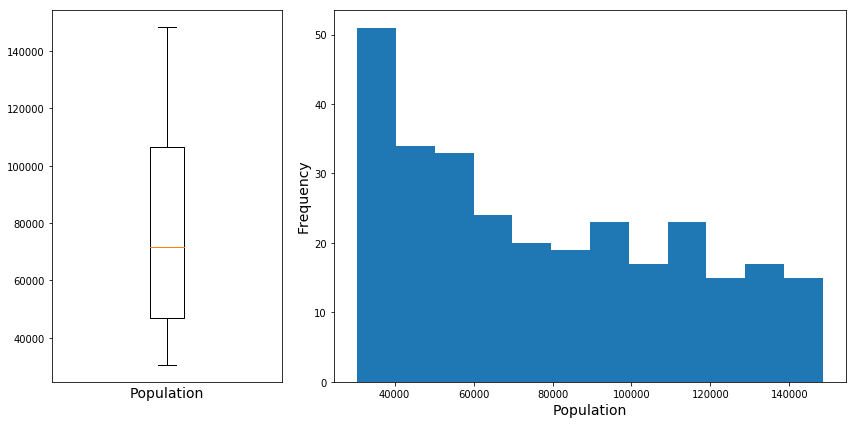

In [9]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,3)

ax1 = fig.add_subplot(gs[0,:1])
ax1.boxplot(df_T['Population'])
ax1.set_xlabel('Population', fontsize=14)
ax1.get_xaxis().set_ticks([])

ax2 = fig.add_subplot(gs[0,1:])
ax2.hist(df_T['Population'], bins=12)
ax2.set_xlabel('Population', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

All towns have populations between 30k and 150k. From the histogram plot, we can see that as the population increases, number of university towns decreases. Half of the towns have populations less than 70000. For a typical public university, such as Iowa State University where the total enrolled students are about 35000, the student size can count nearly half of the total town population.

#### Visualize the university towns on a map
To show the towns on a map, let's first create a new column indicating the population interval each town is in. While mapping, we can use different colors to represent its population size.

In [11]:
# color scheme based on populations
notes = ['pop ~ (30000, 60000)', 'pop ~ (60000, 90000)', 'pop ~ (90000, 120000)', 'pop ~ (120000, 150000)']

binsize = 4
x = np.arange(binsize)
ys = [i + x + (i*x)**2 for i in range(binsize)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
city_color = [colors.rgb2hex(i) for i in colors_array]

# create the interval based on population
pop_bin = [i for i in range(30000, 160000, 30000)]
df_T['Pop_interval'] = pd.cut(df_T['Population'], bins=pop_bin).cat.rename_categories([0, 1, 2, 3])
print('Population interval has been added to df_T.')

Population interval has been added to df_T.


We can now create the US map to show the selected university towns. The map is **interactive** and once each town is clicked, a popup message will show the name and population of the town.

In [12]:
# create map of US using latitude and longitude values
# Color of the cities represent the population size
latitude = 37.0902
longitude = -95.7129
print('The geograpical coordinates of US are {}, {}.'.format(latitude, longitude))
print('The colors used for cities are ', city_color)

map_US = folium.Map(location=[latitude, longitude], zoom_start=4)
# add markers to map
cc = 0
for lat, lng, town, pop, pop_interval in zip(df_T['lat'], df_T['lng'],
                                        df_T['Town'], df_T['Population'], df_T['Pop_interval']):
    note_pop = notes[int(pop_interval)]
    label = '{}\npop={}'.format(town, int(pop))
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color=city_color[int(pop_interval)],
        fill=True,
        fill_color=city_color[int(pop_interval)],
        fill_opacity=0.7,
        parse_html=False).add_to(map_US)  
    cc = cc+1

#  Add the legend to the map
# '#0d0887', '#9c179e', '#ed7953', '#f0f921'
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 40px; left: 30px; width: 150px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Population interval <br>
                              &nbsp; (30k, 60k] &nbsp; <i class="fa fa-circle" style="color:#0d0887"></i><br>
                              &nbsp; (60k, 90k] &nbsp; <i class="fa fa-circle" style="color:#9c179e"></i><br>
                              &nbsp; (90k, 120k] &nbsp; <i class="fa fa-circle" style="color:#ed7953"></i><br>
                              &nbsp; (120k, 150k] &nbsp; <i class="fa fa-circle" style="color:#f0f921"></i>
                </div>
                ''' 

map_US.get_root().html.add_child(folium.Element(legend_html))
map_US

The geograpical coordinates of US are 37.0902, -95.7129.
The colors used for cities are  ['#0d0887', '#9c179e', '#ed7953', '#f0f921']


University towns with larger population sizes are usually close to the largest metropolitan areas in US, such as Los Angeles, Dallas, Houston, Chicago, etc.

### University analysis<a id="2.2"></a>

In [13]:
import seaborn as sns
from seaborn import pairplot
sns.set(font_scale=1.5)

Plot the pairwise relationships.

In [14]:
# usecols = ['size', 'ownership', 'adm_rate', 'avg_sat', 'avg_cost', 'fed_loan', 'pell_grant', 'pop_ratio']
df_U = pd.read_csv('x_UData.csv', index_col=0, usecols=[0,6,7,8,9,10,11,12,13])

df_U['ownership'] = df_U['ownership'].astype(int)
df_U['ownership'] = df_U['ownership'].astype(str)
df_U = df_U.dropna()
df_U.reset_index(drop=True, inplace=True)
# rename the ownership values to 'Public' and 'Private'
df_U['ownership'] = df_U['ownership'].replace(to_replace='1', value='Public')
df_U['ownership'] = df_U['ownership'].replace(to_replace='2', value='Private')
df_U.sample(n=5)

,size,ownership,adm_rate,avg_sat,avg_cost,fed_loan,pell_grant,pop_ratio
167,2466.0,Public,0.6897,1090.0,15483.0,0.3724,0.2009,0.051566
178,1413.0,Private,0.6333,1069.0,47704.0,0.7990,0.4307,0.011650
195,916.0,Private,0.7126,1112.0,31631.0,0.7414,0.4506,0.024428
104,12750.0,Public,0.8737,1123.0,20580.0,0.5391,0.3884,0.360200
89,3186.0,Private,0.8428,1216.0,49398.0,0.6603,0.2738,0.095458


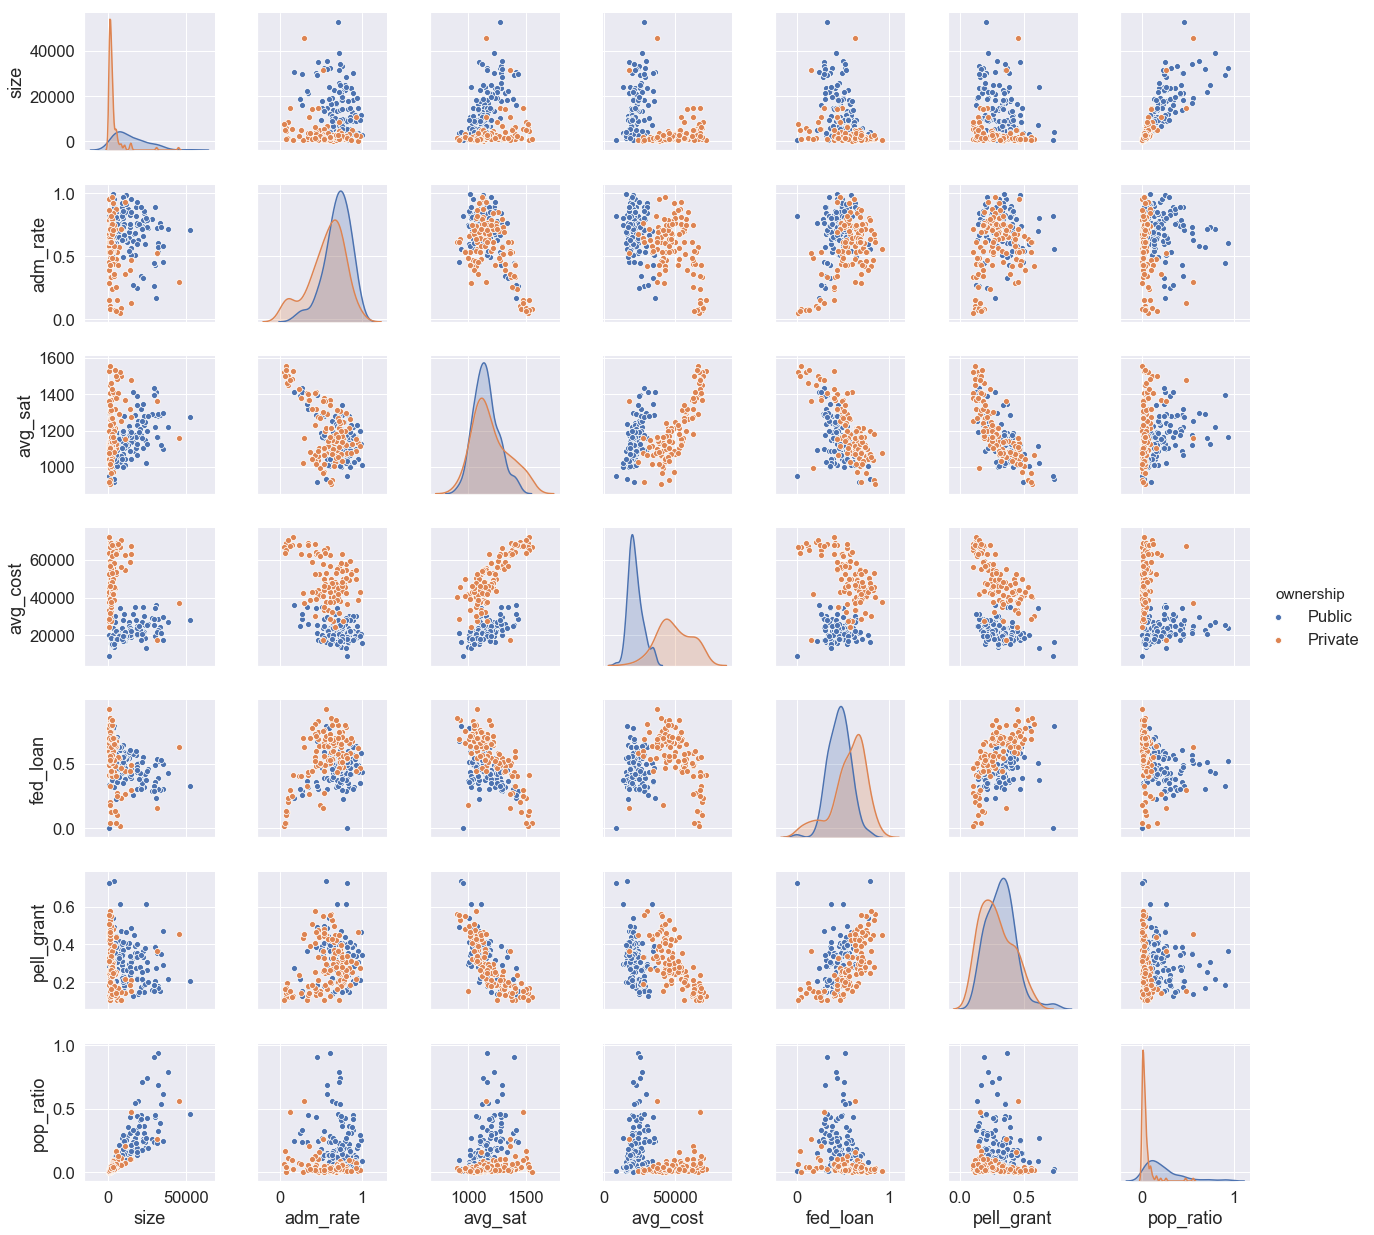

In [15]:
g = sns.pairplot(df_U, hue="ownership")

From the pairplot, we can make the following observations for the selected universities (that are located in **university towns**).
- The private and public universities can be well distinguished through some features, such as size (or pop_ratio, which is  linearly correlated with size), avg_cost.
    - Private schools usually have less enrolled students.
    - Private schools usually are more expensive to attend.
- Private school tends to have smaller acceptance rate and higher average SAT scores.
- Higher percentage of students in private school recieved federal loan and less recieved Pell Grant.
- The average SAT score seems to show rough linear relations with several features, in particular, it negatively correlats with the Federal Loan and Pell Grant ratio, which can also be seen from the following Pearson Correlation coefficient.

In [16]:
# get the pairwise correlation matrix of columns
df_U[['size', 'adm_rate', 'avg_sat', 'avg_cost', 'fed_loan', 'pell_grant', 'pop_ratio']].corr()

,size,adm_rate,avg_sat,avg_cost,fed_loan,pell_grant,pop_ratio
size,1.000000,-0.003570,0.249106,-0.376942,-0.384025,-0.116861,0.828082
adm_rate,-0.003570,1.000000,-0.546452,-0.495796,0.294237,0.179976,0.000086
avg_sat,0.249106,-0.546452,1.000000,0.520135,-0.571115,-0.726926,0.224972
avg_cost,-0.376942,-0.495796,0.520135,1.000000,0.040239,-0.416610,-0.345023
fed_loan,-0.384025,0.294237,-0.571115,0.040239,1.000000,0.450857,-0.309671
pell_grant,-0.116861,0.179976,-0.726926,-0.416610,0.450857,1.000000,-0.145407
pop_ratio,0.828082,0.000086,0.224972,-0.345023,-0.309671,-0.145407,1.000000


#### Ratio between University student size and Town population

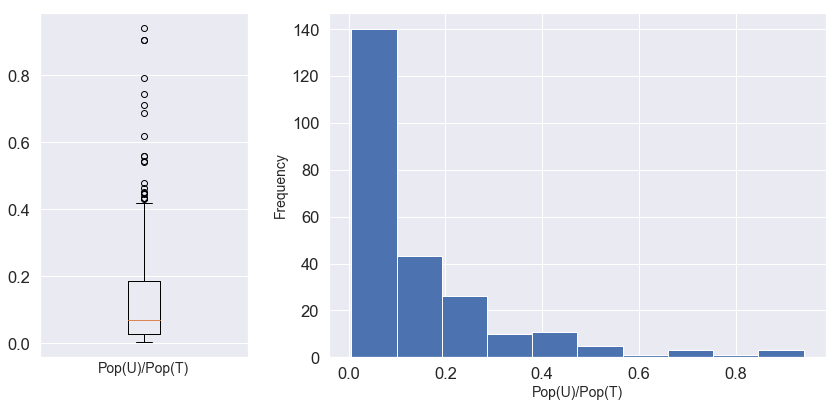

In [17]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(1,3)

ax1 = fig.add_subplot(gs[0,:1])
ax1.boxplot(df_U['pop_ratio'])
ax1.set_xlabel('Pop(U)/Pop(T)', fontsize=14)
ax1.get_xaxis().set_ticks([])

ax2 = fig.add_subplot(gs[0,1:])
ax2.hist(df_U['pop_ratio'], bins=10)
ax2.set_xlabel('Pop(U)/Pop(T)', fontsize=14)
ax2.set_ylabel('Frequency', fontsize=14)
plt.tight_layout()
plt.show()

As we mentioned above, one of the main characters of **university town** is that students are a major fraction of the total population and the university/institution plays an important role throughout the community. From above plot, we do see that more than 25% of those towns have > 20% of the population as students. Some even have > 50% of the population as students.

## Clustering the University Towns<a id="3"></a>
This part explores the venues near the selected university towns and cluster them based on the local life style.

In [ ]:
df_T = pd.read_csv('x_TData.csv', index_col=0)

### (a) Venue exploration<a id="3.1"></a>

In [19]:
# Set up Foursquare API
# To run the following, replace *** with the correct client info.
CLIENT_ID = '***'       # your Foursquare ID
CLIENT_SECRET = '***'   # your Foursquare Secret
VERSION = '20190505' # Foursquare API version

print('Your credentails for Foursquare API are all set.')

Your credentails for Foursquare API are all set.


In [33]:
# Function to get nearby venues
def getNearbyVenues(names, latitudes, longitudes, radius=1000, max_print = 20):
    # Input: names of the towns, location coordinates of the towns, and radius to scan
    # Output: Dataframe storing all the venue information and a counter list to store the number of 
    # venues found for each town
    venues_list=[]
    v_counts = []
    printed = 0
    for name, lat, lng in zip(names, latitudes, longitudes):           
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        count = len(results)
        if printed < max_print:
            print(name, ': venue count = ', count)
            
        printed += 1
        v_counts.append(count)
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Town', 
                  'Town Latitude', 
                  'Town Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues, v_counts)

In [34]:
# Set up explore parameters
radius = 6000
LIMIT = 200

# during the venue exploration, I found that due to geo mislocation (e.g. Norman, Oklahoma),
# very few venues returned (4 for Norman, Oklahoma). The following corrects the location for Norman:    
df_T['lat'].iloc[219] = 35.2226
df_T['lng'].iloc[219] = -97.4395

df_T.to_csv('x_US_UTown_To_Be_Analyzed.csv', encoding='utf-8')

# get venue data
utown_venues, v_counts = getNearbyVenues(names=df_T['Town'],
                                         latitudes=df_T['lat'],
                                         longitudes=df_T['lng'],
                                         radius=radius,
                                         max_print=10)
print('\nFinished.')

Auburn, Alabama : venue count =  100
Dothan, Alabama : venue count =  100
Florence, Alabama : venue count =  100
Tuscaloosa, Alabama : venue count =  100
Fairbanks, Alaska : venue count =  89
Flagstaff, Arizona : venue count =  100
Lake Havasu City, Arizona : venue count =  97
Prescott, Arizona : venue count =  100
Conway, Arkansas : venue count =  100
Fayetteville, Arkansas : venue count =  100

Finished.


Now we have collected the venues for the selected university towns.

In [36]:
# save to file for future use
utown_venues.to_csv('x_US_UTown_Venue.csv', encoding='utf-8')
print('Venue DataFrame saved into "x_US_UTown_Venue.csv".')
print('shape of the obtained venues = ', utown_venues.shape)
print('Most town venues = ', max(v_counts))
print('Least town venues = ', min(v_counts))
print('There are {} uniques categories.'.format(len(utown_venues['Venue Category'].unique())))
print('Random five rows of the dataframe:')
utown_venues.sample(5)

Venue DataFrame saved into "x_US_UTown_Venue.csv".
shape of the obtained venues =  (28027, 7)
Most town venues =  100
Least town venues =  40
There are 479 uniques categories.
Random five rows of the dataframe:


,Town,Town Latitude,Town Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
8048,"Fort Myers, Florida",26.6195,-81.8302,Square 1 Burgers & Bar,26.584014,-81.870568,Burger Joint
5510,"Whittier, California",33.9678,-118.0188,Rockies Frozen yogurt,33.950149,-118.010284,Frozen Yogurt Shop
16891,"Columbia, Missouri",38.9478,-92.3258,Harold's Doughnuts,38.950065,-92.327509,Donut Shop
24121,"Georgetown, Texas",30.6664,-97.6937,Panera Bread,30.633516,-97.697282,Bakery
25742,"Orem, Utah",40.2983,-111.6993,Costa Vida,40.327095,-111.710725,Mexican Restaurant


In [37]:
# find how many of the venues have the word "Restaurant" in the name
print('Number of venues with "Restaurant" in their venue category',
      utown_venues[['Restaurant' in s for s in utown_venues['Venue Category']]].shape[0])

Number of venues with "Restaurant" in their venue category 7148


We can see that although we set LIMIT = 200, but the maximum number of venues we get using Foursquare is 100.    
On average, each town has 28027/291 ~ 96 venues.    
Among the 28027 venue places, 7148 (<span style="color:red">**~1/3**</span>) of them have the word "Restaurant" in it. We can see food-related venues are very popular in the university towns.

### (b) K-means clustering<a id="3.2"></a>

In [38]:
# one hot encoding
utown_onehot = pd.get_dummies(utown_venues[['Venue Category']], prefix="", prefix_sep="")
# add town column back to dataframe
utown_onehot['Town'] = utown_venues['Town'] 
# move City column to the first column
fixed_columns = [utown_onehot.columns[-1]] + list(utown_onehot.columns[:-1])
utown_onehot = utown_onehot[fixed_columns]

utown_grouped = utown_onehot.groupby('Town').mean().reset_index()
print('shape of the grouped dataframe = ', utown_grouped.shape)
utown_grouped.head()

shape of the grouped dataframe =  (291, 480)


,Town,ATM,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport,Airport Service,Airport Terminal,American Restaurant,...,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo
0,"Abilene, Texas",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.06,...,0.0,0.0,0.0,0.01,0.00,0.0,0.02,0.0,0.00,0.01
1,"Albany, Georgia",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,...,0.0,0.0,0.0,0.00,0.01,0.0,0.01,0.0,0.00,0.00
2,"Albany, New York",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.05,...,0.0,0.0,0.0,0.01,0.01,0.0,0.01,0.0,0.02,0.00
3,"Alhambra, California",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01,...,0.0,0.0,0.0,0.01,0.00,0.0,0.00,0.0,0.01,0.00
4,"Allentown, Pennsylvania",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.03,...,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.00


Let's find the top 10 most common venues in each town.

In [39]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10
indicators = ['st', 'nd', 'rd']
# create columns according to number of top venues
columns = ['Town']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
utown_venues_sorted = pd.DataFrame(columns=columns)
utown_venues_sorted['Town'] = utown_grouped['Town']

for ind in np.arange(utown_grouped.shape[0]):
    utown_venues_sorted.iloc[ind, 1:] = return_most_common_venues(utown_grouped.iloc[ind, :], num_top_venues)

print('Shape of the common-venue-sorted dataframe = ', utown_venues_sorted.shape)
utown_venues_sorted.head()

Shape of the common-venue-sorted dataframe =  (291, 11)


,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Abilene, Texas",Mexican Restaurant,American Restaurant,Fast Food Restaurant,Coffee Shop,Grocery Store,Deli / Bodega,Hotel,Restaurant,Burger Joint,Pharmacy
1,"Albany, Georgia",Discount Store,Fast Food Restaurant,Mexican Restaurant,American Restaurant,Sandwich Place,Seafood Restaurant,Fried Chicken Joint,Pharmacy,Gym,Coffee Shop
2,"Albany, New York",Café,American Restaurant,Coffee Shop,Bar,Pub,Italian Restaurant,Sushi Restaurant,Ice Cream Shop,Sports Bar,Donut Shop
3,"Alhambra, California",Chinese Restaurant,Park,Sandwich Place,Bakery,Szechuan Restaurant,Burger Joint,Pizza Place,Convenience Store,Italian Restaurant,Coffee Shop
4,"Allentown, Pennsylvania",Park,Ice Cream Shop,Italian Restaurant,Convenience Store,Pub,Bar,Pizza Place,American Restaurant,Cosmetics Shop,Seafood Restaurant


#### Run k-means to cluster the U Towns into 4 clusters
Next we use **utown_grouped** dataframe with 479 uniques categories as features. Although some of them are actually the same or belong to the same categories, let's run it and see what comes out.

In [40]:
from sklearn.cluster import KMeans
# set number of clusters
kclusters = 4
utown_grouped_clustering = utown_grouped.drop('Town', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(utown_grouped_clustering)

# add clustering labels to sorted utown
utown_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

utown_merged = df_T
utown_merged['Vcount'] = v_counts
utown_merged = utown_merged.join(utown_venues_sorted.set_index('Town'), on='Town')

# save to file for future use
utown_merged.to_csv('x_US_UTown_Merged.csv', encoding='utf-8')
print('DataFrame saved into "x_US_UTown_Merged.csv".')
utown_merged.head()

DataFrame saved into "x_US_UTown_Merged.csv".


,Town,Population,lat,lng,Pop_interval,Vcount,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Auburn, Alabama",63973.0,32.6084,-85.4897,1,100,2,American Restaurant,BBQ Joint,Grocery Store,Coffee Shop,Deli / Bodega,Pizza Place,Burger Joint,Sandwich Place,Mexican Restaurant,Seafood Restaurant
1,"Dothan, Alabama",68202.0,31.2336,-85.4068,1,100,3,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Grocery Store,Steakhouse,Breakfast Spot,Pizza Place,Sandwich Place,Coffee Shop,Hardware Store
2,"Florence, Alabama",39852.0,34.8300,-87.6658,0,100,3,Discount Store,Fast Food Restaurant,Steakhouse,Burger Joint,Asian Restaurant,Seafood Restaurant,Grocery Store,Coffee Shop,Fried Chicken Joint,Mexican Restaurant
3,"Tuscaloosa, Alabama",100287.0,33.2349,-87.5267,2,100,1,Sandwich Place,Mexican Restaurant,Bar,Fast Food Restaurant,Coffee Shop,Pizza Place,Burger Joint,Grocery Store,American Restaurant,Restaurant
4,"Fairbanks, Alaska",31644.0,64.8353,-147.6533,0,89,3,Sandwich Place,Grocery Store,American Restaurant,Convenience Store,Coffee Shop,Clothing Store,Diner,Thai Restaurant,Fast Food Restaurant,Mexican Restaurant


#### Visualize the clustering

In [41]:
# create map
latitude = 37.0902
longitude = -95.7129
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=4)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.plasma(np.linspace(0, 1, len(ys)))
town_color = [colors.rgb2hex(i) for i in colors_array]
print('used color : ', town_color)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(utown_merged['lat'], utown_merged['lng'], utown_merged['Town'], utown_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=4,
        popup=label,
        color=town_color[cluster],
        fill=True,
        fill_color=town_color[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
#  Add the legend to the map
# '#0d0887', '#9c179e', '#ed7953', '#f0f921'
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 40px; left: 30px; width: 150px; height: 110px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Population interval <br>
                              &nbsp; Cluster 0 &nbsp; <i class="fa fa-circle" style="color:#0d0887"></i><br>
                              &nbsp; Cluster 1 &nbsp; <i class="fa fa-circle" style="color:#9c179e"></i><br>
                              &nbsp; Cluster 2 &nbsp; <i class="fa fa-circle" style="color:#ed7953"></i><br>
                              &nbsp; Cluster 3 &nbsp; <i class="fa fa-circle" style="color:#f0f921"></i>
                </div>
                ''' 

map_clusters.get_root().html.add_child(folium.Element(legend_html))
map_clusters

used color :  ['#0d0887', '#9c179e', '#ed7953', '#f0f921']


Interestingly, we can see the clustering of university towns based on venues is quite location dependent. It indicates that **although university towns usually have people gathered from the whole world, the life style of each town is clearly influenced by the regional culture.**     
Let's have a look at some examples in each category:

In [42]:
# cluster 0
utown_merged.loc[utown_merged['Cluster Labels'] == 0, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].sample(n=5)

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,"Merced, California",Coffee Shop,Mexican Restaurant,Burger Joint,Pharmacy,Clothing Store,Gym / Fitness Center,Electronics Store,Grocery Store,Diner,Thai Restaurant
126,"Bettendorf, Iowa",Pizza Place,Coffee Shop,Mexican Restaurant,Sandwich Place,Grocery Store,American Restaurant,Fast Food Restaurant,Ice Cream Shop,Gym,Sushi Restaurant
279,"Lakewood, Washington",Coffee Shop,Pizza Place,Convenience Store,Sandwich Place,Video Store,Grocery Store,Fast Food Restaurant,Golf Course,American Restaurant,Mexican Restaurant
26,"El Cajon, California",Mexican Restaurant,Coffee Shop,Grocery Store,Burger Joint,Sandwich Place,Seafood Restaurant,Steakhouse,Breakfast Spot,Cosmetics Shop,Juice Bar
265,"Cedar City, Utah",Theater,Park,Coffee Shop,Pizza Place,Mexican Restaurant,American Restaurant,Diner,Grocery Store,Juice Bar,Café


In [43]:
# cluster 1
utown_merged.loc[utown_merged['Cluster Labels'] == 1, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].sample(n=5)

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
162,"Lansing, Michigan",Bar,American Restaurant,Coffee Shop,Sandwich Place,Pizza Place,Mexican Restaurant,Chinese Restaurant,BBQ Joint,Fast Food Restaurant,Middle Eastern Restaurant
130,"Iowa City, Iowa",Coffee Shop,Grocery Store,Mexican Restaurant,American Restaurant,Bar,Italian Restaurant,Pizza Place,Sandwich Place,Burrito Place,Bagel Shop
165,"Warren, Michigan",American Restaurant,Bar,Sandwich Place,Pizza Place,Chinese Restaurant,Coffee Shop,Italian Restaurant,Gas Station,Cosmetics Shop,Brewery
157,"Dearborn, Michigan",Middle Eastern Restaurant,Pizza Place,Burger Joint,History Museum,Coffee Shop,Sandwich Place,Grocery Store,Historic Site,American Restaurant,Bar
274,"Harrisonburg, Virginia",Mexican Restaurant,Coffee Shop,American Restaurant,Sandwich Place,Fast Food Restaurant,Bar,Convenience Store,Restaurant,Brewery,Donut Shop


In [44]:
# cluster 2
utown_merged.loc[utown_merged['Cluster Labels'] == 2, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].sample(n=5)

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
225,"Bethlehem, Pennsylvania",American Restaurant,Italian Restaurant,Pub,Café,Salon / Barbershop,Convenience Store,Park,Mexican Restaurant,Pizza Place,Beer Store
191,"New Rochelle, New York",Pizza Place,Italian Restaurant,American Restaurant,Mexican Restaurant,Bagel Shop,Grocery Store,Park,Caribbean Restaurant,Sandwich Place,Bar
108,"Naperville, Illinois",Pizza Place,Coffee Shop,Grocery Store,Yoga Studio,Auto Dealership,Breakfast Spot,American Restaurant,Pet Store,Bakery,Gym
62,"Danbury, Connecticut",Pizza Place,Ice Cream Shop,Italian Restaurant,Middle Eastern Restaurant,Cosmetics Shop,Sushi Restaurant,Park,Coffee Shop,Supermarket,American Restaurant
147,"Cambridge, Massachusetts",Bakery,Pizza Place,Café,Bookstore,Vegetarian / Vegan Restaurant,Brewery,Sandwich Place,Indie Movie Theater,New American Restaurant,Spa


In [45]:
# cluster 3
utown_merged.loc[utown_merged['Cluster Labels'] == 3, utown_merged.columns[[0] + list(range(7, utown_merged.shape[1]))]].sample(n=5)

,Town,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
115,"Columbus, Indiana",American Restaurant,Fast Food Restaurant,Pizza Place,Sandwich Place,Mexican Restaurant,Pharmacy,Burger Joint,Gas Station,Italian Restaurant,Hotel
248,"Edinburg, Texas",Convenience Store,Burger Joint,Mexican Restaurant,Fast Food Restaurant,Pizza Place,Hotel,Grocery Store,Bakery,Discount Store,Video Store
86,"Panama City, Florida",Fast Food Restaurant,Pizza Place,Discount Store,BBQ Joint,Grocery Store,Sandwich Place,Coffee Shop,Mexican Restaurant,Department Store,Clothing Store
4,"Fairbanks, Alaska",Sandwich Place,Grocery Store,American Restaurant,Convenience Store,Coffee Shop,Clothing Store,Diner,Thai Restaurant,Fast Food Restaurant,Mexican Restaurant
254,"Mesquite, Texas",Convenience Store,Fast Food Restaurant,Pizza Place,Mexican Restaurant,American Restaurant,Grocery Store,Burger Joint,Seafood Restaurant,Discount Store,Supermarket


### (c) Analysis of the Venue data <a id="3.3"></a>
Now let's dig deeper into the merged dataframe.

In [2]:
import pandas as pd
import numpy as np
utown_v = pd.read_csv('x_US_UTown_Merged.csv')
utown_v.drop('Unnamed: 0', 1, inplace=True)
utown_v.columns = ['Town', 'Population', 'lat', 'lng', 'pop_interval', 'v_count', 'cluster_label',
                   'common1', 'common2', 'common3', 'common4', 'common5', 'common6', 'common7', 'common8', 'common9', 'common10']
utown_v.head()

,Town,Population,lat,lng,pop_interval,v_count,cluster_label,common1,common2,common3,common4,common5,common6,common7,common8,common9,common10
0,"Auburn, Alabama",63973.0,32.6084,-85.4897,1,100,2,American Restaurant,BBQ Joint,Grocery Store,Coffee Shop,Deli / Bodega,Pizza Place,Burger Joint,Sandwich Place,Mexican Restaurant,Seafood Restaurant
1,"Dothan, Alabama",68202.0,31.2336,-85.4068,1,100,3,American Restaurant,Fast Food Restaurant,Mexican Restaurant,Grocery Store,Steakhouse,Breakfast Spot,Pizza Place,Sandwich Place,Coffee Shop,Hardware Store
2,"Florence, Alabama",39852.0,34.8300,-87.6658,0,100,3,Discount Store,Fast Food Restaurant,Steakhouse,Burger Joint,Asian Restaurant,Seafood Restaurant,Grocery Store,Coffee Shop,Fried Chicken Joint,Mexican Restaurant
3,"Tuscaloosa, Alabama",100287.0,33.2349,-87.5267,2,100,1,Sandwich Place,Mexican Restaurant,Bar,Fast Food Restaurant,Coffee Shop,Pizza Place,Burger Joint,Grocery Store,American Restaurant,Restaurant
4,"Fairbanks, Alaska",31644.0,64.8353,-147.6533,0,89,3,Sandwich Place,Grocery Store,American Restaurant,Convenience Store,Coffee Shop,Clothing Store,Diner,Thai Restaurant,Fast Food Restaurant,Mexican Restaurant


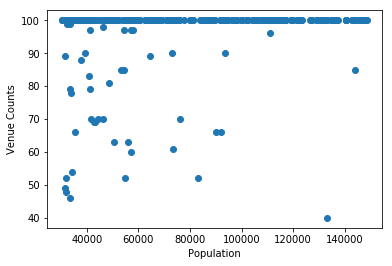

In [4]:
import matplotlib.pyplot as plt
plt.plot(utown_v['Population'], utown_v['v_count'], 'o')
plt.xlabel('Population')
plt.ylabel('Venue Counts')
plt.show()

In the above we plotted venue counts as function of the population.    
Intuitively, we should expect that more venues can be searched for larger towns. But we can see some rather large towns (with population > 100k) only have ~ 50 venues returned from the Foursquare API. This can again be due to the **inaccurate location data** for those cities. 

Next, let's see among the most common venues, how many unique categories there are.

In [11]:
def print_top(top):
    """
    print 5 in a row
    """
    tmp = []
    c = 0
    for t in list(top):
        c += 1
        if c <= 5:
            tmp.append(t)
        else:
            print(tmp)
            c = 0
            tmp = []
    if len(tmp)>0:
        print(tmp)

In [15]:
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utown_v[col].values.tolist()
    top = top.union(set(tmp))
    
print(len(top))
print_top(top)

32
['Fast Food Restaurant', 'Pizza Place', 'American Restaurant', 'Coffee Shop', 'Discount Store']
['Theater', 'Beach', 'Hotel', 'Korean Restaurant', 'Mexican Restaurant']
['Bar', 'Sandwich Place', 'Japanese Restaurant', 'Burger Joint', 'Racetrack']
['Italian Restaurant', 'Bookstore', 'Gym', 'Middle Eastern Restaurant', 'Clothing Store']
['Bakery', 'Gas Station', 'Brewery', 'Park', 'Convenience Store']
['Chinese Restaurant', 'Restaurant']


So, among the most common venues in all the 290 towns, there are 32 unique types. We can see most of them are restaurants (food-related).    
Now let's repeat this for each cluster label,

In [17]:
utmp = utown_v[utown_v['cluster_label']==0]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print('For cluster_label == 0, there are {} unique venue types'.format(len(top)))
print_top(top)

For cluster_label == 0, there are 10 unique venue types
['Pizza Place', 'Sandwich Place', 'American Restaurant', 'Coffee Shop', 'Japanese Restaurant']
['Theater', 'Burger Joint', 'Mexican Restaurant', 'Clothing Store']


In [18]:
utmp = utown_v[utown_v['cluster_label']==1]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print('For cluster_label == 1, there are {} unique venue types'.format(len(top)))
print_top(top)

For cluster_label == 1, there are 12 unique venue types
['Brewery', 'Sandwich Place', 'Pizza Place', 'American Restaurant', 'Coffee Shop']
['Beach', 'Café', 'Restaurant', 'Mexican Restaurant', 'Middle Eastern Restaurant']


In [19]:
utmp = utown_v[utown_v['cluster_label']==2]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print('For cluster_label == 2, there are {} unique venue types'.format(len(top)))
print_top(top)

For cluster_label == 2, there are 18 unique venue types
['Pizza Place', 'American Restaurant', 'Coffee Shop', 'Grocery Store', 'Italian Restaurant']
['Bookstore', 'Gym', 'Mexican Restaurant', 'Korean Restaurant', 'Ice Cream Shop']
['Donut Shop', 'Bakery', 'Park', 'Sandwich Place', 'Burger Joint']


In [20]:
utmp = utown_v[utown_v['cluster_label']==3]
top = set()
for i in range(1,2):
    col = 'common{}'.format(i)
    tmp = utmp[col].values.tolist()
    top = top.union(set(tmp))
    
print('For cluster_label == 3, there are {} unique venue types'.format(len(top)))
print_top(top)

For cluster_label == 3, there are 16 unique venue types
['Fast Food Restaurant', 'Pizza Place', 'American Restaurant', 'Coffee Shop', 'Discount Store']
['Hotel', 'Mexican Restaurant', 'Gas Station', 'Park', 'Sandwich Place']
['Convenience Store', 'Chinese Restaurant', 'Racetrack', 'BBQ Joint']


## Conclusion<a id="4"></a>

Based on current analysis on 291 university towns with population among (30000, 150000), we can conclude that,    
- Food-related venues are most popular in the university towns in US.   
- Considering the most common venue category, <span style="color:red">**Restaurant**</span>, <span style="color:red">**Coffee Shop**</span>, and <span style="color:red">**Convenience/Grocery Store**</span> are most frequent in all the 4 clusters we grouped into.   
- The clustering of the university towns based on venue distributions shows <span style="color:red">**clear dependency on the geometrical location of the town**</span>, indicating that the life style of each town is clearly influenced by the regional culture although people in the universities usually comes from all over the US/world.      

By devoting more time to this, there are a few ways to improve the analysis:
- We could find ways to combine the 479 venue categories into **more representative features**, so that the clustering may give better results. Also, if **extra information about the towns** can be gathered, such as household income of each town, population ethnicity etc., we can do better clustering on the university towns.
- Another improvement can come from **more accurate location data**. Clearly some towns’ location coordinates from the online resource are not very accurate, resulting in incomplete/wrong venue information. 
- If there is no **limitation from Foursquare API** (i.e. it is possible to obtain a more comprehensive exploration of the nearby venues), the clustering of the university towns can also be improved. Ways to collect more data using Foursquare need to be studied.